In [1]:
from gen_dataset import *


def fetch_filter_data(filters):
    filter_dict = {}

    for name, filepath in filters:
        try:
            with open(filepath, 'r') as file:
                wavelength, transmission = [], []

                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        try:
                            wavelength.append(float(parts[0]))
                            transmission.append(float(parts[1]))
                        except ValueError:
                            continue  # Skip malformed lines

                filter_dict[name] = {
                    "wl": wavelength,
                    "tr": transmission
                }
        except FileNotFoundError:
            print(f"File not found for {name}: {filepath}")
        except Exception as e:
            print(f"Error reading file for {name}: {e}")

    return filter_dict

# Example local filter file paths
filters = [
    ['HSCg', 'HSC_bands/HSC.g_filter.dat'],
    ['HSCr', 'HSC_bands/HSC.r_filter.dat'],
    ['HSCi', 'HSC_bands/HSC.i_filter.dat'],
    ['HSCz', 'HSC_bands/HSC.z_filter.dat'],
    ['HSCY', 'HSC_bands/HSC.Y_filter.dat']
]

filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)


reader = SpectrumReader('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
lages, lmets, flx, wl = reader.read()

# Setup interpolator and processor
interpolator = SpectrumInterpolator(lages, lmets, flx)
processor = SpectrumProcessor(interpolator)

# Setup photometric calculator with filters
photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)

# Create DatasetBuilder with processor, wavelength grid and photocalc
builder = DatasetBuilder(processor, wl, photocalc)

# Generate dataset (already includes photometry and augmentation)
integrals, params, spectra = builder.generate(n_samples=32000, age_range=(50, 15000), young_extinction_prob=0.0, eml_prob=0.9)

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
spectra /= np.max(spectra, axis=1)[:, None]

[ 0.40159562  0.04312948 -0.49830641]


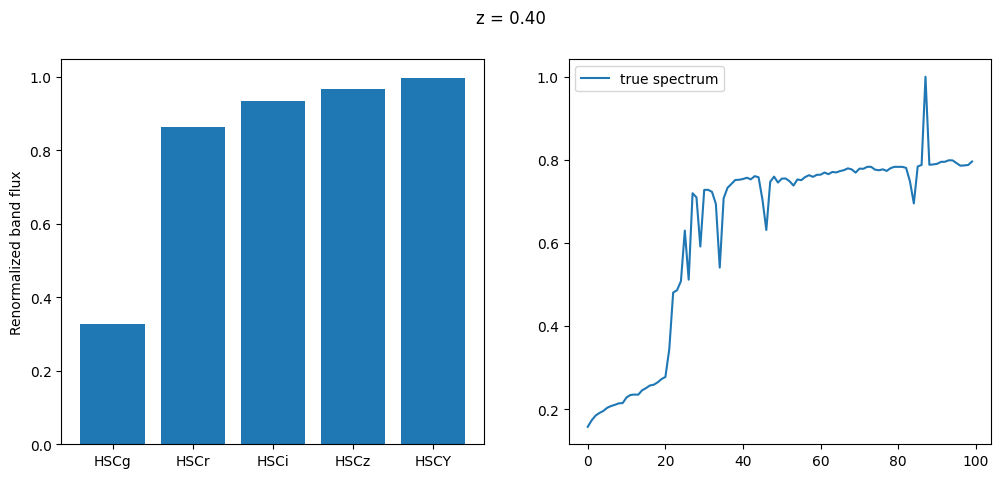

[ 0.40159562  0.04312948 -0.49830641]


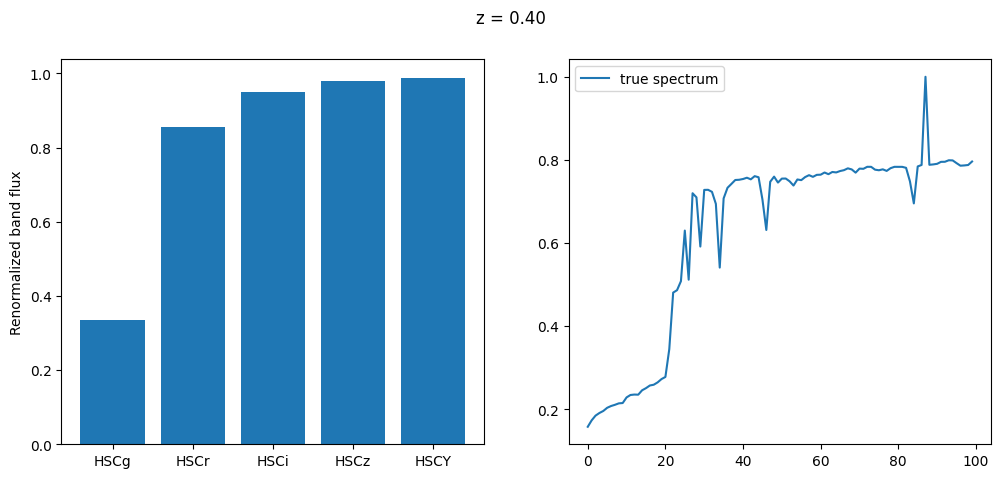

[ 0.40159562  0.04312948 -0.49830641]


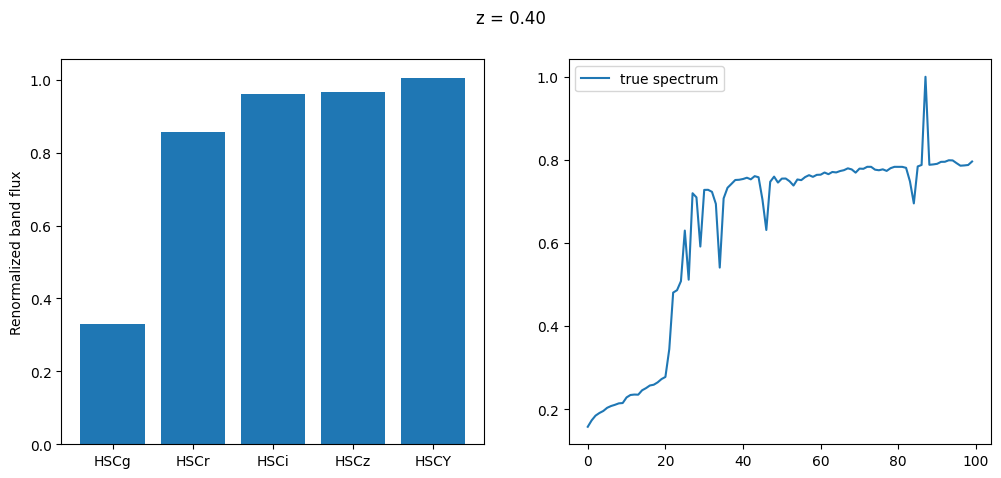

[ 0.40159562  0.04312948 -0.49830641]


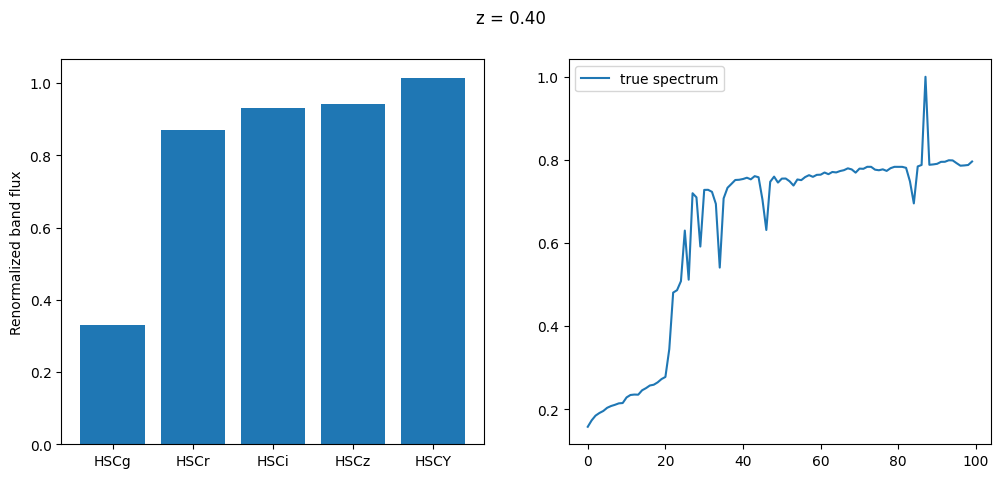

[ 0.40159562  0.04312948 -0.49830641]


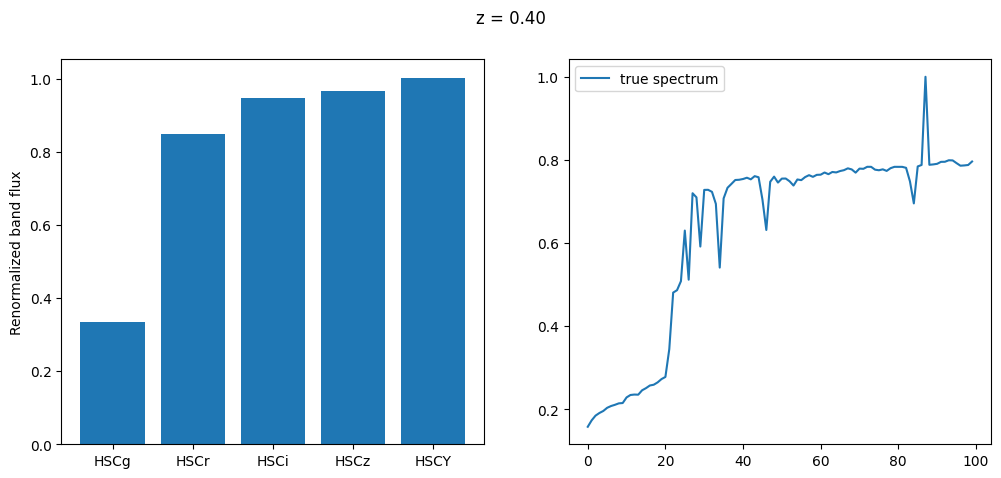

[ 0.40159562  0.04312948 -0.49830641]


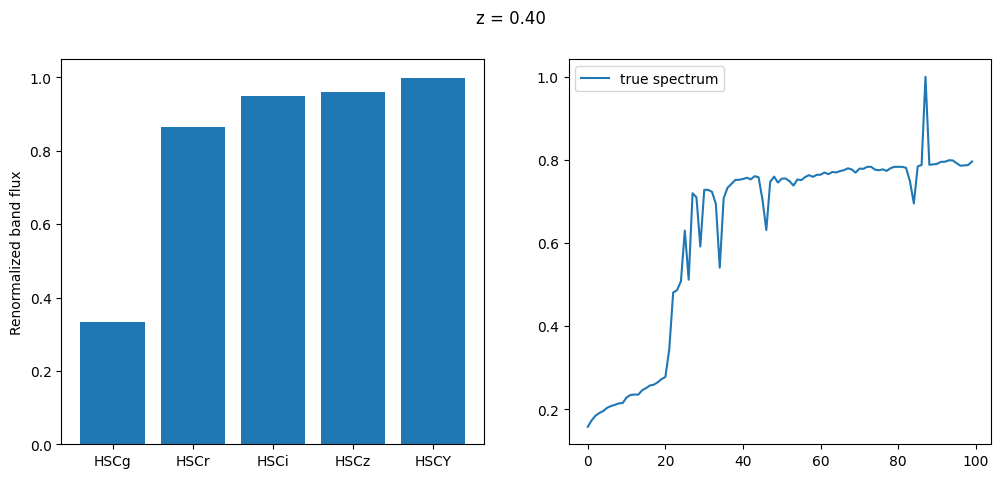

[ 0.40159562  0.04312948 -0.49830641]


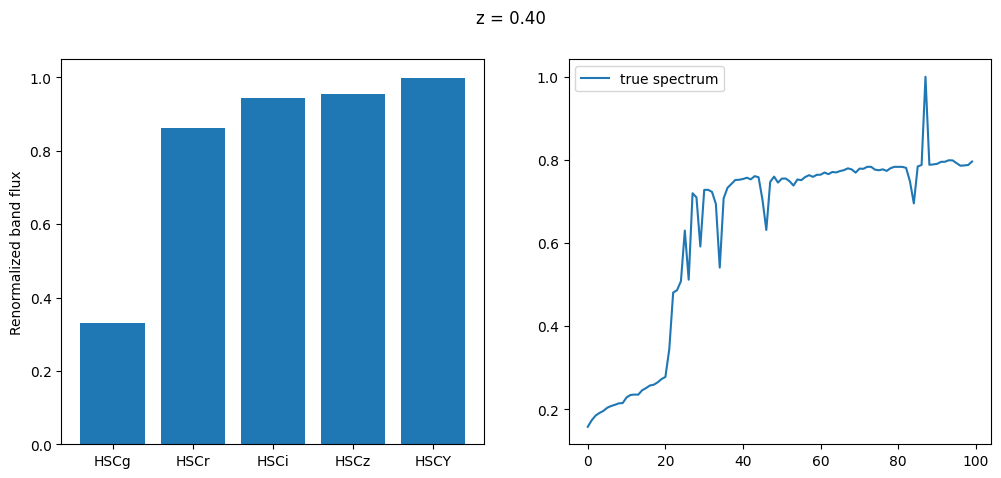

[ 0.40159562  0.04312948 -0.49830641]


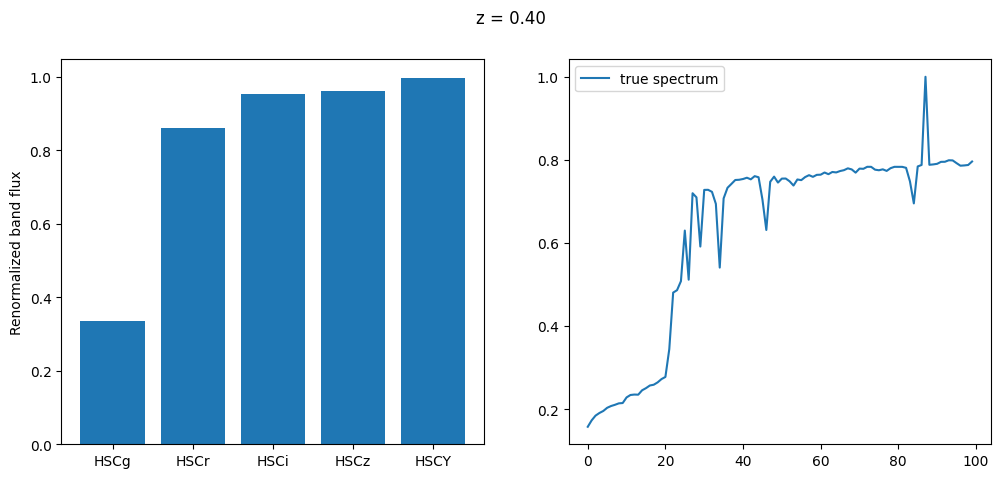

[ 0.40159562  0.04312948 -0.49830641]


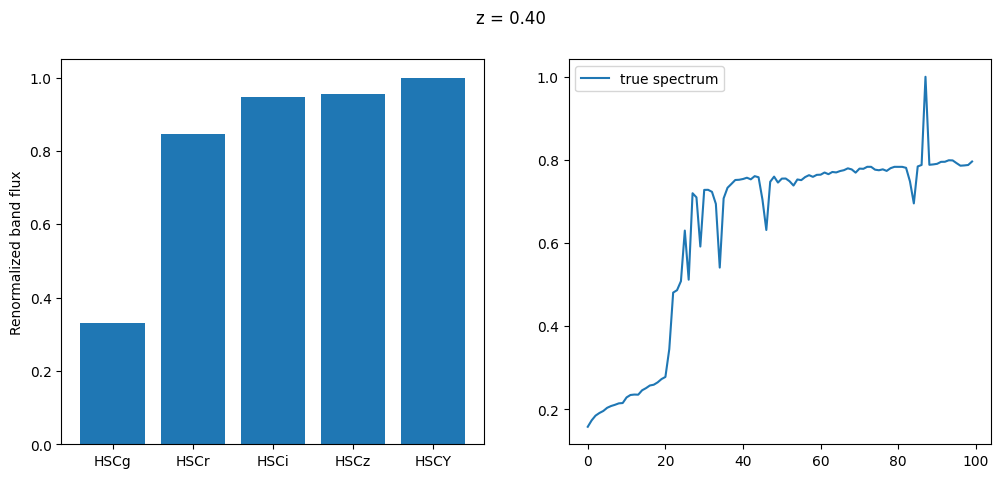

[ 0.40159562  0.04312948 -0.49830641]


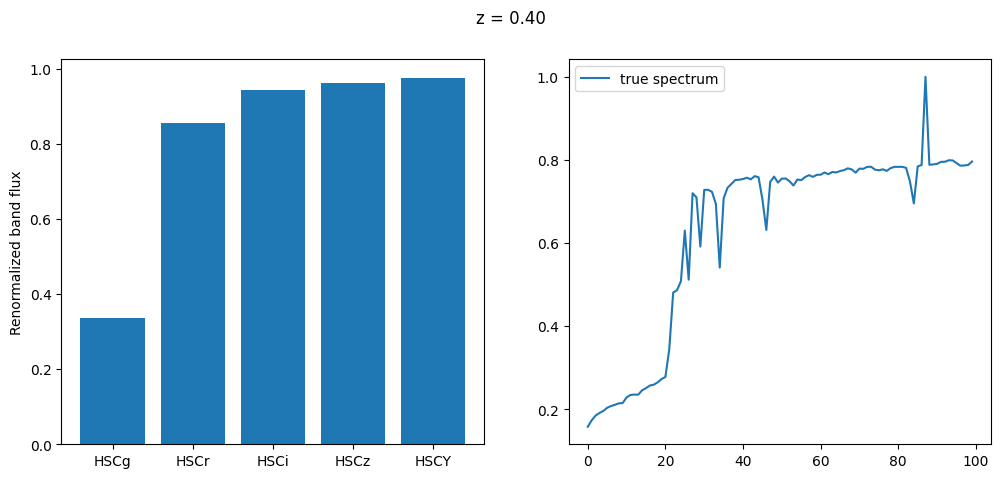

In [11]:
ii=1200
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    #axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [2]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.0) & (t_hsc_['z'] < 0.95))]


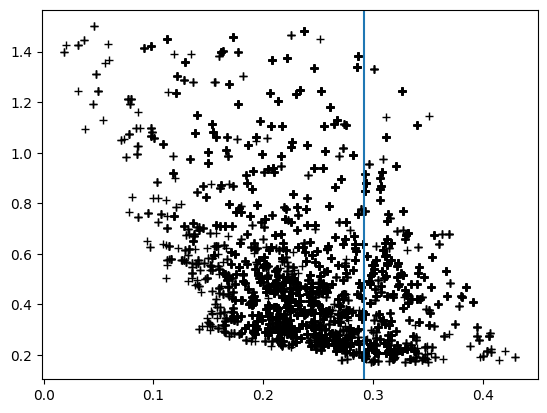

In [21]:
import matplotlib.pyplot as plt

target_id = 39627821533889898

#target_id = 39627791339101782

r = t_hsc[t_hsc['targetid'] == target_id][0]


mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.025**2)[0]

p_v = params[idx]

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(r['z'])
#plt.axhline(r['ssp_age']/1e4)

plt.show()

120


/tmp/ipykernel_286678/2268703893.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


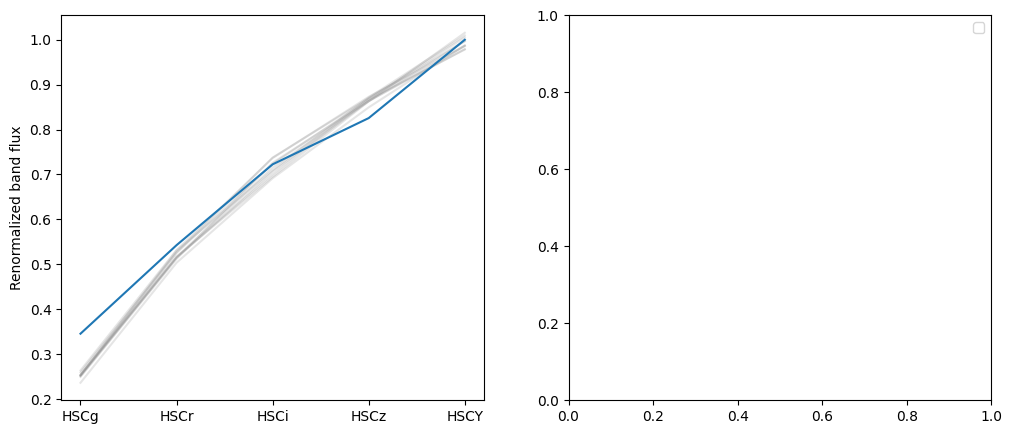

In [20]:
import random
z = r['z']

idx = np.where((np.abs(params[:, 0] - z) < 0.01) & (np.abs(params[:, 1] - 0.31) < 0.01))[0]

print(len(idx))

random.shuffle(idx)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
for i in range(0, 10):
    comp = integrals[idx[i]]
    axs[0].plot(filer_names, comp, color='grey', alpha=0.2)

axs[0].plot(filer_names, bandfl)
axs[0].set_ylabel('Renormalized band flux')
plt.legend()
plt.show()